# ROMY Status File

In [48]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import obspy as obs
import matplotlib.colors

from pandas import DataFrame
from andbro__save_to_pickle import __save_to_pickle

In [49]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [50]:
from functions.load_beat import __load_beat
from functions.load_mlti import __load_mlti
from functions.get_mlti_intervals import __get_mlti_intervals

## Configurations

In [51]:
config = {}


# config['tbeg'] = obs.UTCDateTime(sys.argv[1])
# config['tend'] = obs.UTCDateTime(sys.argv[1])+86400

config['tbeg'] = obs.UTCDateTime("2023-09-01")
config['tend'] = obs.UTCDateTime("2023-09-02")

config['ring'] = "Z"

config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_figures'] = archive_path+f"romy_plots/{config['tbeg'].year}/R{config['ring']}/status/"

config['path_to_output'] = archive_path+f"temp_archive/{config['tbeg'].year}/BW/R{config['ring']}/"

config['fsagnac_rings'] = {"U":303, "V":447.5, "W":447.5, "Z":553.5}
config['fsagnac_nominal'] = config['fsagnac_rings'][config['ring']]

config['DC_threshold'] = 0.1

config['AC_threshold'] = 0.3


### Load MLTI Logs

In [52]:
mlti_log = __load_mlti(config['tbeg'], config['tend'], config['ring'], archive_path)

mlti_t1, mlti_t2 = __get_mlti_intervals(mlti_log.time_utc, time_delta=100)

### Load Beat Data

In [53]:
beat = __load_beat(config['tbeg'], config['tend'], config['ring'], config['path_to_autodata'])

In [54]:
beat

,times_utc,times_utc_sec,times_mjd,fj,f1,f2,pz,p1,p2,ac_z,ac_1,ac_2,dc_z,dc_1,dc_2,contrast_z,contrast_1,contrast_2
3,2023-09-01T00:00:30.000000Z,30.0,60188.000347,553.498654,0.0,0.0,0.391005,0.0,0.0,0.944117,0.0,0.0,0.490530,0.0,0.0,0.892886,0.0,0.0
4,2023-09-01T00:01:30.000000Z,90.0,60188.001042,553.498639,0.0,0.0,0.391095,0.0,0.0,0.944302,0.0,0.0,0.490638,0.0,0.0,0.892896,0.0,0.0
5,2023-09-01T00:02:30.000000Z,150.0,60188.001736,553.498622,0.0,0.0,0.391122,0.0,0.0,0.944336,0.0,0.0,0.490678,0.0,0.0,0.892870,0.0,0.0
6,2023-09-01T00:03:30.000000Z,210.0,60188.002431,553.498603,0.0,0.0,0.391190,0.0,0.0,0.944393,0.0,0.0,0.490718,0.0,0.0,0.892870,0.0,0.0
7,2023-09-01T00:04:30.000000Z,270.0,60188.003125,553.498593,0.0,0.0,0.391160,0.0,0.0,0.944387,0.0,0.0,0.490729,0.0,0.0,0.892863,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1438,2023-09-01T23:55:30.000000Z,86130.0,60188.996875,553.496942,0.0,0.0,0.388658,0.0,0.0,0.933387,0.0,0.0,0.487715,0.0,0.0,0.891786,0.0,0.0
1439,2023-09-01T23:56:30.000000Z,86190.0,60188.997569,553.497005,0.0,0.0,0.388540,0.0,0.0,0.933118,0.0,0.0,0.487578,0.0,0.0,0.891798,0.0,0.0
0,2023-09-01T23:57:30.000000Z,86250.0,60188.998264,553.497060,0.0,0.0,0.388547,0.0,0.0,0.933088,0.0,0.0,0.487560,0.0,0.0,0.891810,0.0,0.0
1,2023-09-01T23:58:30.000000Z,86310.0,60188.998958,553.497113,0.0,0.0,0.388670,0.0,0.0,0.933295,0.0,0.0,0.487673,0.0,0.0,0.891811,0.0,0.0


### Define Variables

In [55]:
status = DataFrame()

status['times_utc'] = beat.times_utc
status['times_utc_sec'] = beat.times_utc_sec

N = status.shape[0]

quality = np.ones(N)
fsagnac = np.ones(N)
mlti = np.ones(N)
dc_threshold = np.ones(N)
ac_threshold = np.ones(N)

## Determine Status

In [56]:
idx_mlti = 0

for idx in range(beat.shape[0]):

    _time = obs.UTCDateTime(status.times_utc.iloc[idx])

    ## check if time conincides with MLTI
    # print(_time, mlti_t1[idx_mlti], mlti_t2[idx_mlti])
    if _time >= mlti_t1[idx_mlti] and _time <= mlti_t2[idx_mlti]:
        quality[idx] = 0
        mlti[idx] = 0

    ## update mlti interval
    if _time > mlti_t2[idx_mlti] and idx_mlti < len(mlti_t1)-1:
        idx_mlti += 1

    if beat.fj.iloc[idx] < config['fsagnac_nominal'] - 0.3 or beat.fj.iloc[idx] > config['fsagnac_nominal'] + 0.3:
        quality[idx] = 0
        fsagnac[idx] = 0

    if beat.dc_z.iloc[idx] < config['DC_threshold']:
        quality[idx] = 0
        dc_threshold[idx] = 0

    if beat.ac_z.iloc[idx] < config['AC_threshold']:
        quality[idx] = 0
        ac_threshold[idx] = 0


status['quality'] = quality
status['fsagnac'] = fsagnac
status['mlti'] = mlti
status['ac_threshold'] = ac_threshold
status['dc_threshold'] = dc_threshold


## store output to file
print(f"-> store: {config['path_to_output']}R{config['ring']}_{config['tbeg'].date}_status.pkl")
__save_to_pickle(status, config['path_to_output'],f"R{config['ring']}_{config['tbeg'].date}_status")


-> store: /home/andbro/freenas/temp_archive/2023/BW/RZ/RZ_2023-09-01_status.pkl

 -> created:  /home/andbro/freenas/temp_archive/2023/BW/RZ/RZ_2023-09-01_status.pkl


### Plotting

In [57]:
arr = np.ones((3, status['quality'].size))

arr[0] *= status['quality']
arr[1] *= status['fsagnac']
arr[2] *= status['mlti']

Text(0.5, 1.0, 'Quality Status of RZ on 2023-09-01')

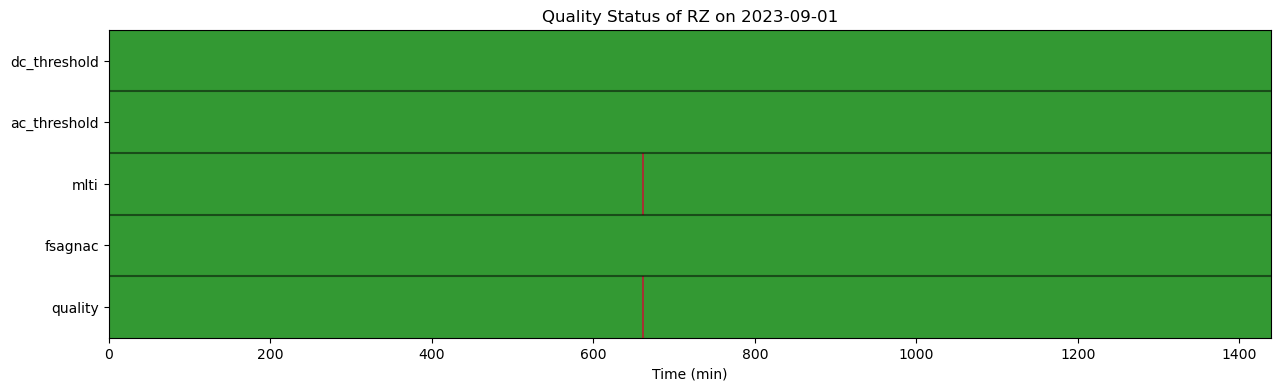

In [58]:
names = ["quality", "fsagnac", "mlti", "ac_threshold", "dc_threshold"]
bars = np.ones(len(names))-0.5

arr = np.ones((len(names), status['quality'].size))

for _n, name in enumerate(names):
    arr[_n] *= status[name]


cmap = matplotlib.colors.ListedColormap(['darkred', 'green'])

fig = plt.figure(figsize=(15, 4))

c = plt.pcolormesh(np.arange(0, arr.shape[1]), names, arr, cmap=cmap, rasterized=True, alpha=0.8)

for _k, bar in enumerate(bars):
    plt.axhline(bar+_k, color="k", alpha=0.5)

plt.xlabel("Time (min)")


plt.title(f"Quality Status of R{config['ring']} on {config['tbeg'].date}")

# plt.show();


# print(f" -> stored: {config['path_to_figures']}R{config['ring']}_{config['tbeg'].date}_status.png")
# fig.savefig(config['path_to_figures']+f"R{config['ring']}_{config['tbeg'].date}_status.png", format="png", dpi=100, bbox_inches='tight')